In [1]:
import sys
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/gaussfiltax')
from jax import jit, jacfwd, jacrev
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import gaussfiltax.static_utils as ts
import gaussfiltax.utils as utils
import scienceplots
from typing import NamedTuple
from jaxtyping import Float32
from itertools import count
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import tensorflow_probability.substrates.jax.distributions as tfd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

## Plot Ellipses

In [21]:
f = lambda x : jnp.dot(x, x)

dx = 2
Nprt = 100
mu = jnp.array([0.00001, 0.00001])
cov = 1 * jnp.eye(2)
Q = 0.1 * jnp.eye(1)
y0 = 1.0
hessian = jit(jacfwd(jacrev(f)))
hess = hessian(mu)
Delta =  0.1 * cov #utils.sdp_opt(2, cov, hess, 1, 0.01)
model = ts.AugmentedJointApproximation(Nprt, f, dx, 1, mu, cov, Q, Delta)
keys = map(jr.PRNGKey, count(11))
posterior = model.return_posterior([y0], keys)[0]
grads = model.return_posterior([y0], keys)[1]

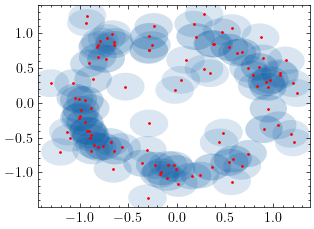

In [34]:
plt.style.use('science')
ax = plt.gca()
p = posterior.weights
p = np.asarray(p).astype('float64')
p = p / np.sum(p)
idx = np.random.choice(Nprt, 100, replace=True, p=p)
for i in range(Nprt):
    ts.plot_cov_ellipse(posterior.covs[i], posterior.means[i], nstd=0.2, ax=ax, alpha=20*p[i])
plt.scatter(posterior.means[:, 0], posterior.means[:, 1], s=1, c='r')
plt.show()

## Variance of the Weights

In [ ]:
dx_max = 40
dy = 1

# f = lambda x : jnp.eye(dy, dx) @ x
f = lambda x : jnp.array([jnp.dot(x, x)])

p1arr = np.zeros(dx_max-1)
p2arr = np.zeros(dx_max-1)
for dx in range(2,dx_max):
    Nprt = 100
    mu = jnp.ones(dx)
    cov = 1 * jnp.eye(dx)
    Q = 1e-1 * jnp.eye(dy)
    y0 = jnp.ones(dy)
    jac = jit(jacfwd(f))
    hessian = jit(jacfwd(jacrev(f)))
    hess = hessian(mu)


    Delta1 =  0.0 * cov #utils.sdp_opt(2, cov, hess, 1, 0.01)
    model1 = ts.AugmentedJointApproximation(Nprt, f, dx, dy, mu, cov, Q, Delta1)
    keys1 = map(jr.PRNGKey, count(Nprt))
    posterior1, grads1 = model1.return_posterior(y0, keys1)
    p1 = posterior1.weights

    # Delta2 =  0.8 * cov 
    hess_ = hessian(mu)
    jac_ = jac(mu)
    Delta2 = utils.sdp_opt(dx, Nprt, cov, jac_, hess_, 1)
    model2 = ts.AugmentedJointApproximation(Nprt, f, dx, dy, mu, cov, Q, Delta2)
    keys2 = map(jr.PRNGKey, count(Nprt))
    posterior2, grads2 = model2.return_posterior(y0, keys2)
    p2 = posterior2.weights

    p1arr[dx-2] = jnp.std(p1)
    p2arr[dx-2] = jnp.std(p2)
    
    print('IS', jnp.std(p1))
    # print('Delta2', Delta2)
    print('AIS', jnp.std(p2))

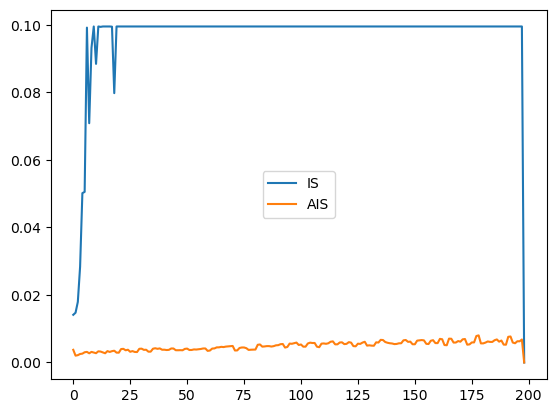

In [15]:
plt.plot(p1arr, label='IS')
plt.plot(p2arr, label='AIS')
plt.legend()
plt.show()